# Library

In [1]:
# My library
from molgraph.dataset import *
from molgraph.graphmodel import *
from molgraph.training import *
from molgraph.testing import *
from molgraph.visualize import *
from molgraph.interpret import *
from molgraph.experiment import *
# General library
import argparse
import numpy as np
from sklearn.metrics import jaccard_score
# pytorch
import torch
import pytorch_lightning as pl

from IPython.display import SVG

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

/opt/anaconda3/envs/moleculegraph38/lib/python3.8/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


# Argument

In [2]:
parser = ArgumentParser()
args = parser.getArgument('''
--file 3mr
--model GIN
--schema A
--reduced 
--mol_embedding 256
--batch_normalize
--fold 5
'''.split())

args

Namespace(batch_normalize=True, batch_size=256, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='l05_3mr', fold=5, gpu=-1, grad_norm=1.0, graphtask='classification', heads=1, hidden_channels=256, in_channels=256, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=3, num_layers_reduced=3, num_layers_self=3, num_layers_self_reduced=3, out_channels=256, patience=30, reduced=[], schema='A', seed=42, smiles='SMILES', splitting='splits', splitting_seed=42, task='label_full', vocab_len=100, weight_decay=5e-05)

# Dataset

In [3]:
file = args.file
smiles = args.smiles 
task = args.task
splitting = args.splitting 
splitting_fold = args.fold
splitting_seed = args.splitting_seed

# get validated dataset
datasets = getDataset(file, smiles, task, splitting)
# compute positive weight for classification
if args.graphtask == 'classification':
    args.pos_weight = getPosWeight(datasets)
    print('pos_weight:', args.pos_weight)
# generate dataset splitting
datasets_splitted = generateDatasetSplitting(file, splitting, splitting_fold, splitting_seed)
# generate all graph dataset
datasets_graph = generateGraphDataset(file)
# generate all reduced graph dataset
dict_reducedgraph = dict()
for g in args.reduced:
    if g == 'substructure':
        for i in range(splitting_fold):
            vocab_file = file+'_'+str(i)
            if not os.path.exists('vocab/'+vocab_file+'.txt'):
                generateVocabTrain(file, splitting_seed, splitting_fold, vocab_len=args.vocab_len)
            dict_reducedgraph[g] = generateReducedGraphDict(file, g, vocab_file=vocab_file)
    else:
        dict_reducedgraph[g] = generateReducedGraphDict(file, g)

Function: getDataset()
number of valid smiles: 2877
pos_weight: 1.5415194346289753
Function: generateDatasetSplitting()
Fold: 5
Fold Number: 0
-- Datasets Train: 1841
-- Datasets Val: 460
-- Datasets Test:  576
-- Total: 2877
Fold Number: 1
-- Datasets Train: 1841
-- Datasets Val: 460
-- Datasets Test:  576
-- Total: 2877
Fold Number: 2
-- Datasets Train: 1841
-- Datasets Val: 460
-- Datasets Test:  576
-- Total: 2877
Fold Number: 3
-- Datasets Train: 1841
-- Datasets Val: 460
-- Datasets Test:  576
-- Total: 2877
Fold Number: 4
-- Datasets Train: 1840
-- Datasets Val: 461
-- Datasets Test:  576
-- Total: 2877
Function: generateGraphDataset()
Datasets graph:  2877


# Test

In [4]:
import os
args_test = dict()

# Load model
ts = "2023-Apr-29-17:24:38"
reduced_list = '_'.join(args.reduced)
args_test['log_folder_name'] = os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list, f"{ts}"])
args_test['exp_name'] = args.experiment_number
args_test['fold_number'] = 2
args_test['seed'] = args.seed

In [5]:
training_bin = torch.load('./dataset/'+args_test['log_folder_name']+'/checkpoints/training_args.bin')

args.batch_size = training_bin.batch_size
args.num_layers = training_bin.num_layers
args.num_layers_reduced = training_bin.num_layers_reduced
args.in_channels = training_bin.in_channels
args.hidden_channels = training_bin.hidden_channels
args.out_channels = training_bin.out_channels
args.edge_dim = training_bin.edge_dim
args.num_layers_self = training_bin.num_layers_self
args.num_layers_self_reduced = training_bin.num_layers_self_reduced
args.dropout = training_bin.dropout
args.lr = training_bin.lr
args.weight_decay = training_bin.weight_decay

args

Namespace(batch_normalize=True, batch_size=16, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='l05_3mr', fold=5, gpu=-1, grad_norm=1.0, graphtask='classification', heads=1, hidden_channels=256, in_channels=256, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=4, num_layers_reduced=3, num_layers_self=3, num_layers_self_reduced=3, out_channels=256, patience=30, pos_weight=1.5415194346289753, reduced=[], schema='A', seed=42, smiles='SMILES', splitting='splits', splitting_seed=42, task='label_full', vocab_len=100, weight_decay=5e-05)

In [6]:
# test with dataset
# test_loader, datasets_test =  generateDataLoaderTesting(datasets_graph[1], args.batch_size)
# test_loader, datasets_test =  generateDataLoaderTesting([datasets_graph[1][360]], 1)
test_loader, datasets_test =  generateDataLoaderTesting(args.file, 1)
sample_to_test = datasets_test[8]

all_dataset_test = datasets_test

# all dataset
all_dataset = datasets_graph
# all_dataset = {d.smiles: d for d in datasets_test}
print(len(all_dataset))

test_loader, datasets_test =  generateDataLoaderListing([sample_to_test], 1)

molecule_test = datasets_test[0]
print(molecule_test)


2877
PairData(smiles='COc1cccc(C2OC2C(=O)c2cc3c(cc2N)OCO3)c1', x_g=[23, 79], edge_index_g=[2, 52], edge_attr_g=[52, 10], y=[1, 1])


In [7]:
# # test with t = sample
molecule_test = [constructGraph('Cc1cccc(OCC(=O)Nc2cccc3ccccc23)c1', 1)]
test_loader = DataLoader(molecule_test, batch_size=1, shuffle=True, follow_batch=['x_g', 'x_r'])
molecule_test = molecule_test[0]

In [8]:
tester = Tester(args, args_test)
# tester.test(test_loader, return_attention_weights=True)
tester.test_single(test_loader, return_attention_weights=True)

GNN_Combine(
  (node_feature_graph): NodeLinear(
    (lin1): Linear(in_features=79, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (edge_feature_graph): EdgeLinear(
    (lin1): Linear(in_features=10, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GNN_Graph): GNN_Graph(
    (convs): ModuleList(
      (0): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (leakyrelu1): LeakyReLU(negative_slope=0.01)
          (lin2): Linear(in_features=256, out_features=256, bias=True)
        )
      ))
      (1): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, e

tensor([[False]])

In [9]:
# att = tester.getAttention()
att_mol = tester.getAttentionMol()
if 'atom' in att_mol:
    if len(args.reduced) >= 1:
        sample_att = (att_mol['atom'], att_mol[args.reduced[0]])
    else:
        sample_att = (att_mol['atom'], None)
else:
    sample_att = (None, att_mol[args.reduced[0]])
sample_graph = molecule_test

[16:18:17] The new font size 1 is below the current minimum (6).


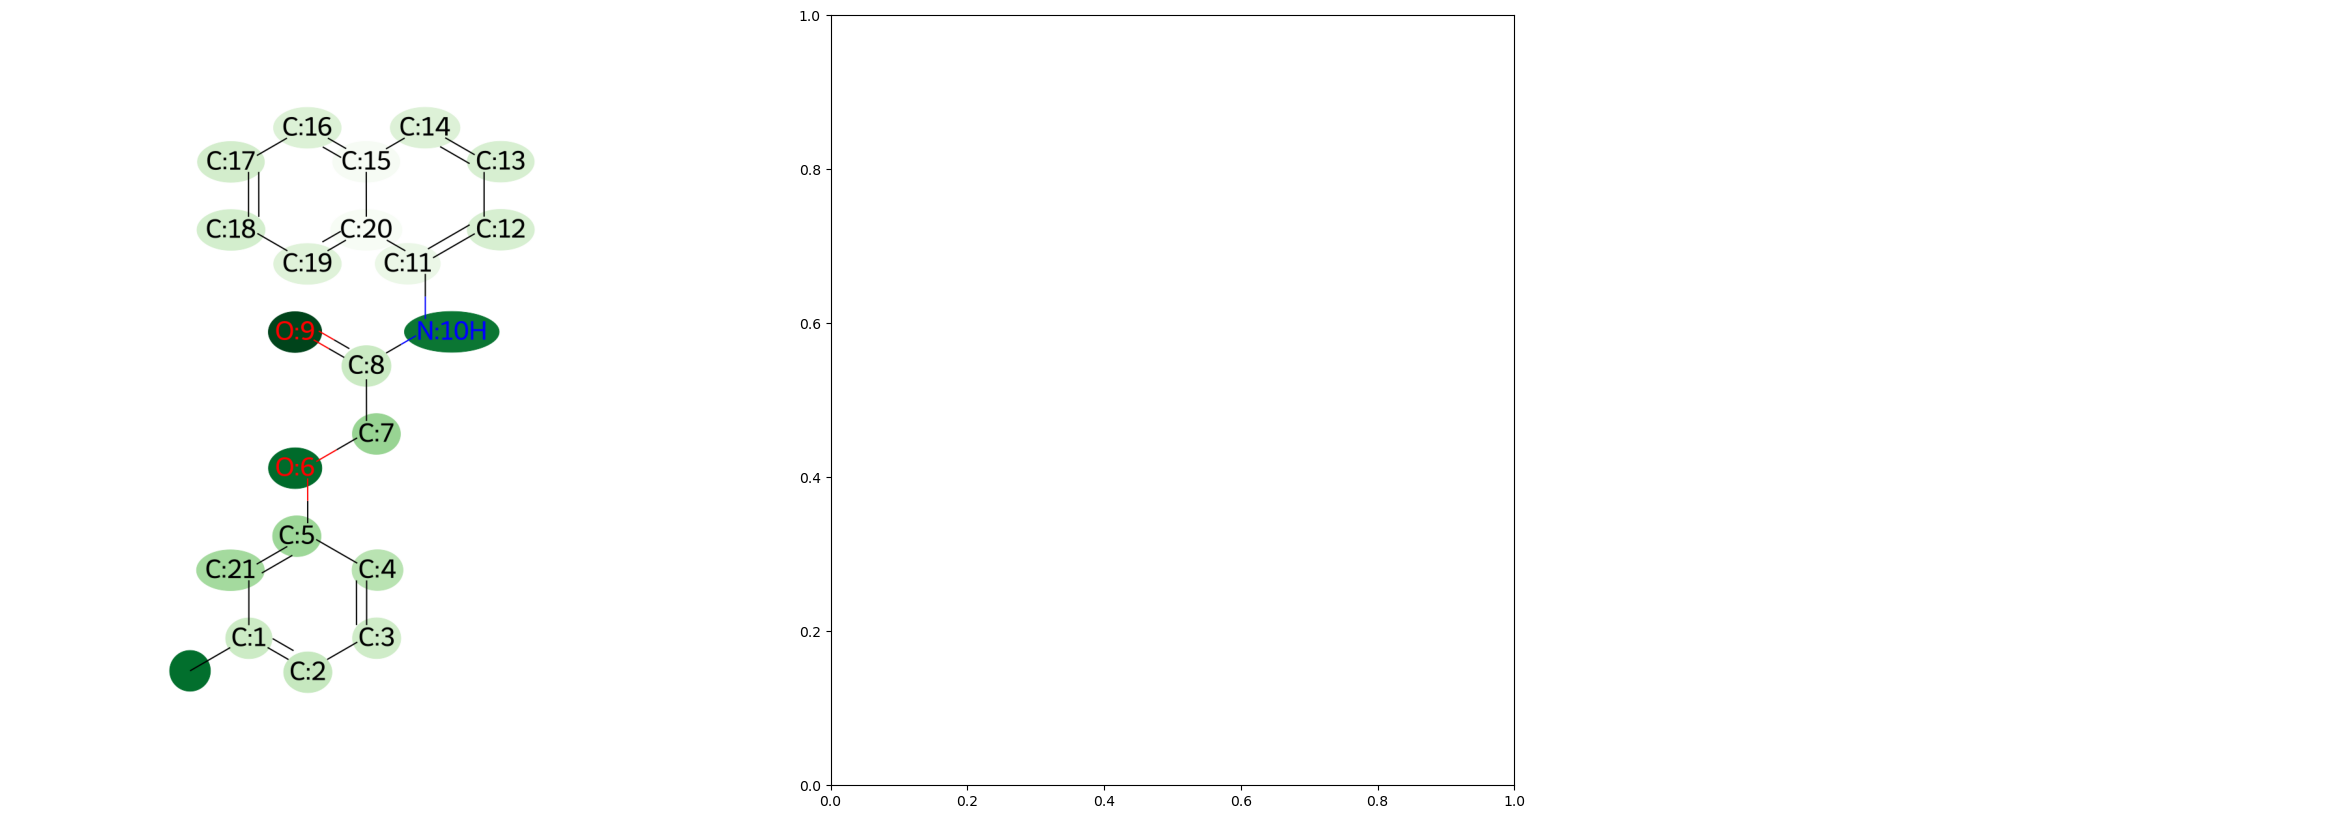

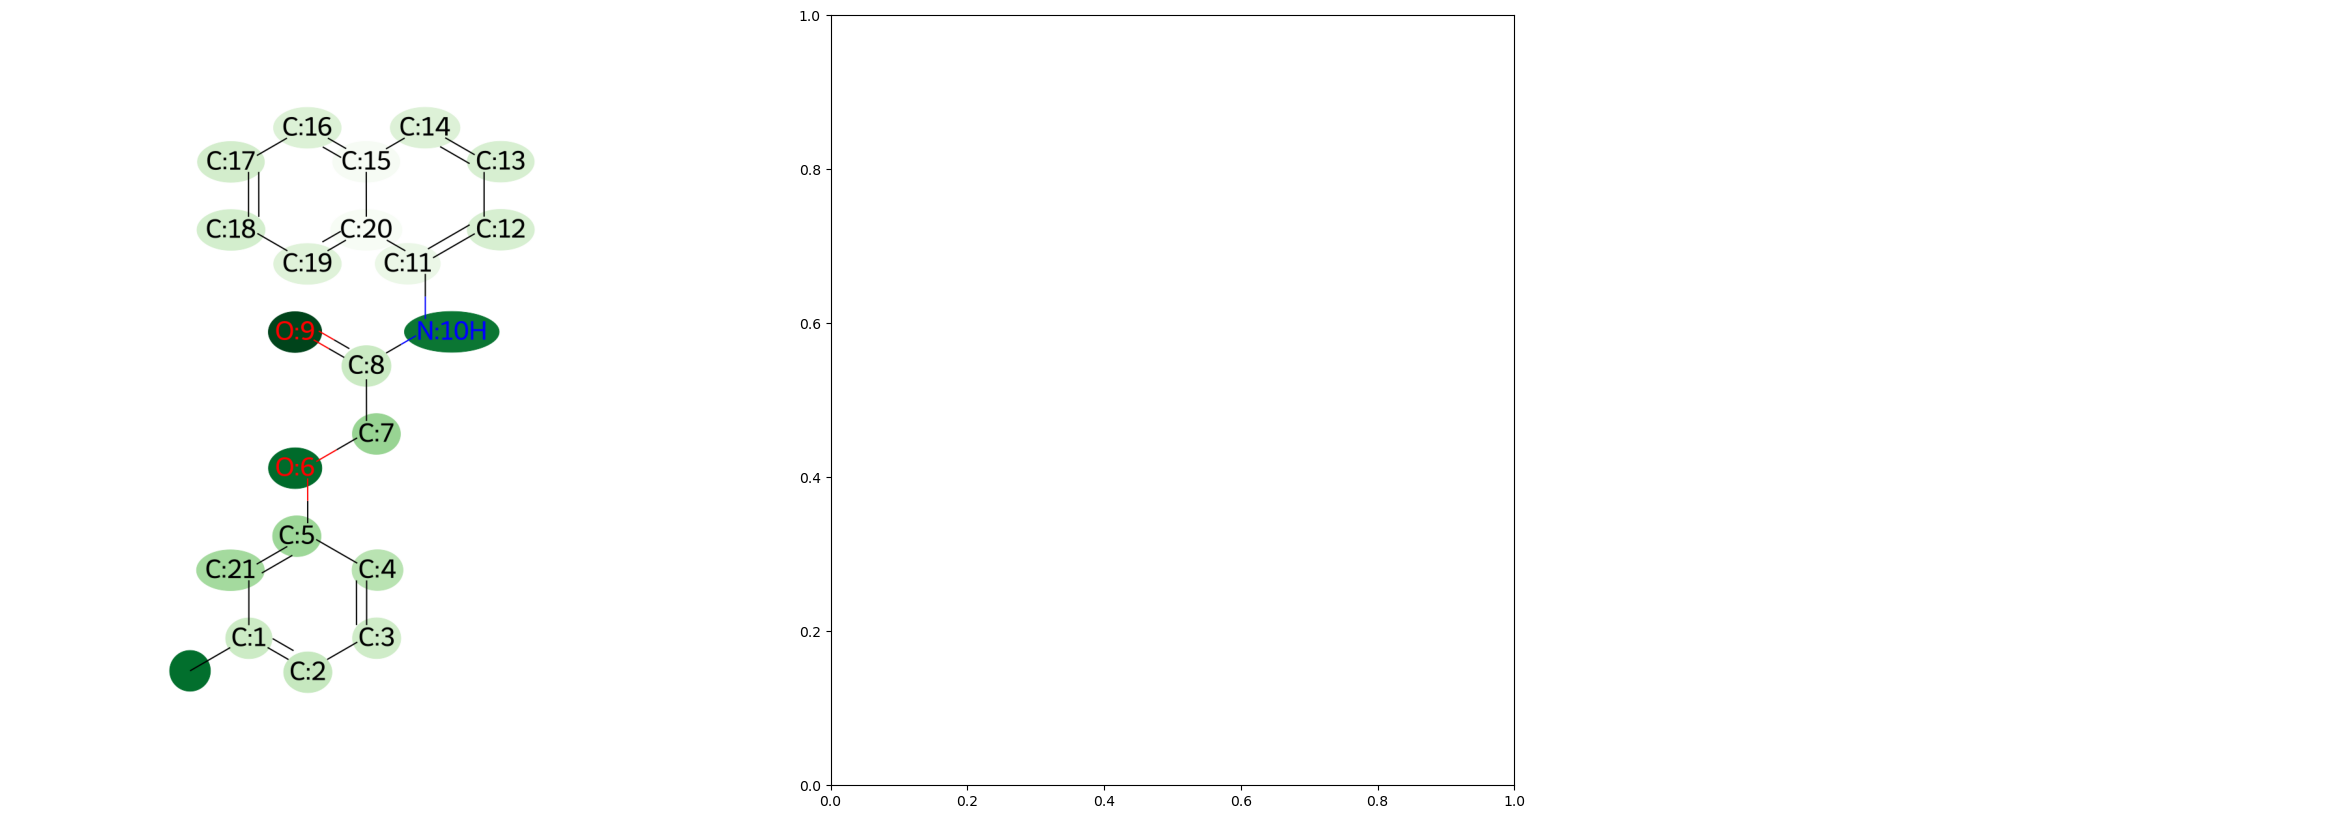

In [13]:
plot_attentions(args, sample_graph, sample_att)

# Test Compound

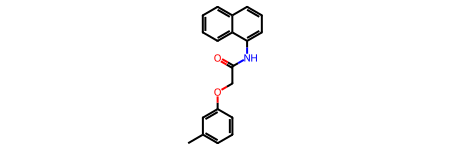

In [14]:
Chem.MolFromSmiles(molecule_test.smiles)

In [15]:
from locale import normalize
from rdkit import Chem
smiles = sample_graph.smiles
mol = Chem.MolFromSmiles(smiles)

if args.schema in ['A']:
    reduced_graph, cliques, edges = getReducedGraph(args, ['atom'], smiles, normalize=False)
else:
    reduced_graph, cliques, edges = getReducedGraph(args, args.reduced, smiles, normalize=False)
# print(reduced_graph.node_features)

sample_att_g, sample_att_r = sample_att
if args.schema in ['A', 'R_N', 'AR', 'AR_0', 'AR_N']:
    mask_graph_g = mask_graph(sample_att_g)
if args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
    mask_graph_r = mask_reduced(sample_att_r)
if not args.schema in ['A']:
    mask_graph_x = mask_rtog(smiles, cliques, mask_graph_r)
    if args.schema in ['AR', 'AR_0', 'AR_N']:
        mask_graph_x = mask_gandr(mask_graph_g, mask_graph_x)
        display_interpret_weight(mol, None, None, mask_graph_x, None, scale=True)

In [16]:
if args.schema in ['A']:
    feature_importance = dict()
    for i, f in enumerate(reduced_graph.node_features):
        f_tuple = tuple(f)
        if f_tuple in feature_importance:
            feature_importance[f_tuple].append(mask_graph_g['atom'][i])
        else:
            feature_importance[f_tuple] = [mask_graph_g['atom'][i]]
elif args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
    feature_importance = dict()
    for i, f in enumerate(reduced_graph.node_features):
        f_tuple = tuple(f)
        if f_tuple in feature_importance:
            feature_importance[f_tuple].append(mask_graph_r['atom'][i])
        else:
            feature_importance[f_tuple] = [mask_graph_r['atom'][i]]

# Running

In [20]:
import scipy
from sklearn.metrics import roc_auc_score
def pearson_r_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Pearson's r for linear correlation."""
    r, _ = scipy.stats.pearsonr(y_true, y_pred)
    return r[0] if hasattr(r, 'ndim') and r.ndim == 1 else r

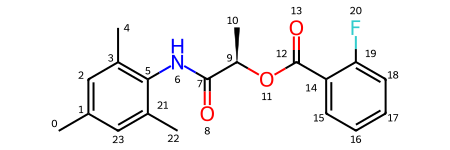

In [21]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
mollll = Chem.MolFromSmiles('Cc1cc(C)c(NC(=O)[C@@H](C)OC(=O)c2ccccc2F)c(C)c1')
mollll

In [22]:
"""Code to identify fragments in molecules."""
import abc
import functools
import itertools
from typing import Any, Iterator, List, Optional, Sequence, Text, Tuple

import numpy as np
from rdkit import Chem


def _sparse_to_dense(sparse_indices: List[int], max_value) -> np.ndarray:
    dense_array = np.zeros([max_value], dtype=np.bool_)
    dense_array[sparse_indices] = 1
    return dense_array


def _nonnull_powerset(iterable) -> Iterator[Tuple[Any]]:
    """Returns powerset of iterable, minus the empty set."""
    s = list(iterable)
    return itertools.chain.from_iterable(
        itertools.combinations(s, r) for r in range(1, len(s) + 1))


def _reduce_logical_or(arrays: Sequence[np.ndarray], array_size) -> np.ndarray:
    initial_value = np.zeros(array_size, dtype=np.bool_)
    return functools.reduce(np.logical_or, arrays, initial_value)


def _reduce_logical_and(
        arrays: Sequence[np.ndarray], array_size) -> np.ndarray:
    initial_value = np.ones(array_size, dtype=np.bool_)
    return functools.reduce(np.logical_and, arrays, initial_value)


class AbstractFragmentRule(metaclass=abc.ABCMeta):
    """Class encapsulating fragment identification logic."""

    @abc.abstractmethod
    def match(self, mol: Chem.Mol) -> List[np.ndarray]:
        """Return a list of all possible masking arrays.

        For example, if the matching rule is "Nitrogen", and the molecule is NCCN:
        >>> BasicFragmentRule('nitrogen', -'N').match(Chem.MolFromSmiles('NCCN')
        ...
        [np.ndarray([1, 0, 0, 0]),
         np.ndarray([1, 0, 0, 1]),
         np.ndarray([0, 0, 0, 1])]

        This is because there are many possible correct answers when trying to
        answer the question, "Why did you think there was a N in this molecule?".

        Args:
          mol: Molecule to test for fragments.

        Returns: List of legal fragment masks.
        """


class BasicFragmentRule(AbstractFragmentRule):
    """Single fragment identifier."""

    def __init__(self, label: Text, smarts: Text,
                 description: Optional[Text] = None):
        self.label = label
        self.smarts = smarts
        self.pattern = Chem.MolFromSmarts(smarts)
        self.description = description
        # Update properties, sometimes rings or valence info is not set.
        self.pattern.UpdatePropertyCache()
        Chem.rdmolops.FastFindRings(self.pattern)

    def __len__(self):
        """Gets size of matched fragment."""
        return self.pattern.GetNumAtoms()

    def substruct_matches(self, mol: Chem.Mol) -> List[List[int]]:
        """Gets all matching substructs as a list of sparse indice lists."""
        return list(map(list, mol.GetSubstructMatches(self.pattern)))

    def match(self, mol: Chem.Mol) -> List[np.ndarray]:
        matches = self.substruct_matches(mol)
        mol_size = mol.GetNumAtoms()
        dense_matches = [_sparse_to_dense(index_list, mol_size)
                         for index_list in matches]
        all_matches = [_reduce_logical_or(match_set, mol_size)
                       for match_set in _nonnull_powerset(dense_matches)]
        return all_matches


class CompositeRule(AbstractFragmentRule):
    """Multiple fragment identifier."""

    def __init__(self, rule_type: Text,
                 fragment_logics: List[AbstractFragmentRule]):
        self.rule_type = rule_type
        self.fragment_logics = fragment_logics

    @classmethod
    def or_(cls, fragment_logics):
        return cls('OR', fragment_logics)

    @classmethod
    def and_(cls, fragment_logics):
        return cls('AND', fragment_logics)

    @property
    def label(self):
        rule_str = {'OR': ' | ', 'AND': ' & '}[self.rule_type]
        labels = [rule.label for rule in self.fragment_logics]
        return f'({rule_str.join(labels)})'

    def match(self, mol: Chem.Mol) -> List[np.ndarray]:
        subrule_matches = [logic.match(mol) for logic in self.fragment_logics]
        mol_size = mol.GetNumAtoms()
        composite_matches = []
        for combination in itertools.product(*subrule_matches):
            if self.rule_type == 'OR':
                for match_subset in _nonnull_powerset(combination):
                    composite_matches.append(
                        _reduce_logical_or(
                            match_subset, mol_size))
            elif self.rule_type == 'AND':
                composite_matches.append(
                    _reduce_logical_or(
                        combination, mol_size))
        return composite_matches

In [23]:
_frag_rule = BasicFragmentRule
def _and_rules(rules): return CompositeRule('AND', rules)
def _or_rules(rules): return CompositeRule('OR', rules)

In [24]:
class AromaticDetection:
    def __init__(self, aromatic=True):
        self.aromatic = aromatic

    def match(self, mol):
        atom_aromaticity = []
        for atom in mol.GetAtoms():
            if atom.GetIsAromatic():
                atom_aromaticity.append(1)
            else:
                atom_aromaticity.append(0)
                
        return [atom_aromaticity]

In [25]:
tmr_dataset = _and_rules(
            [_frag_rule('tmr', '*1**1')])

aromatic_dataset = _and_rules(
            [_frag_rule('aromatic', '[a!r0]')])
             
logic6_dataset = _and_rules(
            [_frag_rule('flouride', '[FX1]'),
             _frag_rule('carbonyl', '[CX3]=O')])


logic7_dataset = _and_rules([
            _frag_rule('unbranched alkane', '[R0;D2,D1][R0;D2][R0;D2,D1]'),
            _frag_rule('carbonyl', '[CX3]=O')
        ])
logic9_dataset = _and_rules([
            _frag_rule('amine', '[NX3;H2]'),
            _frag_rule('ether2', '[OD2](C)C'),
            _frag_rule('benzene', '[cX3]1[cX3H][cX3H][cX3H][cX3H][cX3H]1')
        ])
# logic14_dataset = _and_rules([
#             _or_rules([_frag_rule('[OX2H]', '[OX2H]'), _frag_rule('[OD2](C)(C)', '[OD2](C)(C)')]),
#             _frag_rule('[CX3]=O', '[CX3]=O'),
#             _frag_rule('[CX2]#[CX2]', '[CX2]#[CX2]')
#         ])
logic14_dataset = _and_rules([_frag_rule('[CX3]=O', '[CX3]=O')])

logic14_dataset_or = _and_rules([_frag_rule('[OD2](C)(C)', '[OD2](C)(C)')])

logic14_dataset_false = _and_rules([_frag_rule('[CX2]#[CX2]', '[CX2]#[CX2]')])

logic14_dataset_or_false = _and_rules([_frag_rule('[OX2H]', '[OX2H]')])

or_case = False
false_case = False
if args.file == 'logic6':
    logic_dataset = logic6_dataset
elif args.file == 'logic7':
    logic_dataset = logic7_dataset
elif args.file == 'logic9':
    logic_dataset = logic9_dataset
elif args.file == 'logic14':
    logic_dataset = logic14_dataset
    logic_dataset_or = logic14_dataset_or
    or_case = True
    false_case = True
    logic_dataset_false = logic14_dataset_false
    logic_dataset_or_false = logic14_dataset_or_false
elif args.file == '3mr':
    logic_dataset = tmr_dataset
elif args.file == 'aromaticity':
    logic_dataset = AromaticDetection()


# All dataset

In [27]:
feature_importance_all = dict()
feature_importance_smiles_all = dict()
feature_importance = dict()
feature_importance_smiles = dict()
feature_max = dict()
feature_outlier = dict()
feature_topk = dict()

wrong_prediction = dict()

auroc = list()
acc = list()
jac = list()

count = 0 
tester = Tester(args, args_test)

TP, FP, FN, TN = 0, 0, 0, 0

b = False
count_outlier = 0

GNN_Combine(
  (node_feature_graph): NodeLinear(
    (lin1): Linear(in_features=79, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (edge_feature_graph): EdgeLinear(
    (lin1): Linear(in_features=10, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GNN_Graph): GNN_Graph(
    (convs): ModuleList(
      (0): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (leakyrelu1): LeakyReLU(negative_slope=0.01)
          (lin2): Linear(in_features=256, out_features=256, bias=True)
        )
      ))
      (1): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, e

# Run all dataset

In [41]:
non_of_condition = 0
no_important_in_groundtruth = 0

for d in tqdm(all_dataset):
# for d in tqdm(all_dataset_test):
# for d in ['CCOC(=O)C1=C(C)N(C)C(=O)N(C)[C@@H]1c1ccccc1']:
    
    # data loader
    test_loader, datasets_test =  generateDataLoaderListing([all_dataset[d]], 1)
    # test_loader, datasets_test =  generateDataLoaderListing([d], 1)
    molecule_test = datasets_test[0]

    # testing
    # print(datasets_test)
    try:
        predicted = tester.test_single(test_loader, return_attention_weights=True, print_result=False)
    except:
        predicted = None

    if predicted != molecule_test.y:
        wrong_prediction[molecule_test.smiles] = {'TRUE': molecule_test.y, 'PREDICTED': predicted}
        # print(molecule_test.smiles, "TRUE:", molecule_test.y, "PREDICTED:", predicted)

    # print(predicted)
    # if predicted == 1 or args.task == 'graphtask':
    if predicted is not None:
        count += 1

        # attention result
        att_mol = tester.getAttentionMol()
        sample_att = att_mol
        sample_graph = molecule_test
        if 'atom' in sample_att:
            sample_att_g = sample_att['atom']
        else:
            sample_att_g = None
        if len(args.reduced) != 0:
            sample_att_r = sample_att[args.reduced[0]]
        else:
            sample_att_r = None
        # sample_att_g, sample_att_r = sample_att
        if args.schema in ['A', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_g = mask_graph(sample_att_g)
        if args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_r = mask_reduced(sample_att_r)

        # molecule
        smiles = sample_graph.smiles
        mol = Chem.MolFromSmiles(smiles)

        # reduced graph
        if args.schema in ['A']:
            reduced_graph, cliques, edges = getReducedGraph(args, ['atom'], smiles, normalize=False)
        else:
            reduced_graph, cliques, edges = getReducedGraph(args, args.reduced, smiles, normalize=False)

        # record importance
        mask_graph_x = None
        if args.schema in ['A']:
            mask_graph_x = mask_graph_g
        elif args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_x = mask_graph_r

        # # finding outlier
        # q3, q1 = np.percentile(list(mask_graph_x['atom'].values()), [75, 25])
        # iqr = q3 - q1
        # outlier = q3 + 1.5*iqr
        # # finding top-k
        # k = 0.25
        # topk_position = len(list(mask_graph_x['atom'].values()))*0.25
        # topk_sorted = sorted(list(mask_graph_x['atom'].values()), reverse=True)
        # topk = topk_sorted[math.ceil(topk_position)]
        # # finding max
        # f_max = None
        # f_max_value = 0

        # for i, f in enumerate(reduced_graph.node_features):
        #     if args.reduced != 'substructure':
        #         f_tuple = getImportanceFeatures(args.reduced, f)
        #     else:
        #         f_tuple = getImportanceFeatures(args.reduced, reduced_graph.cliques_smiles[i])

        #     # all
        #     if f_tuple in feature_importance_all:
        #         feature_importance_all[f_tuple].append(mask_graph_x['atom'][i])
        #         feature_importance_smiles_all[f_tuple].append(smiles)
        #     else:
        #         feature_importance_all[f_tuple] = [mask_graph_x['atom'][i]]
        #         feature_importance_smiles_all[f_tuple] = [smiles]

        #     if predicted == 1 or args.graphtask == 'regression':

        #         # for class
        #         if f_tuple in feature_importance:
        #             feature_importance[f_tuple].append(mask_graph_x['atom'][i])
        #             feature_importance_smiles[f_tuple].append(smiles)
        #         else:
        #             feature_importance[f_tuple] = [mask_graph_x['atom'][i]]
        #             feature_importance_smiles[f_tuple] = [smiles]
        #         # max
        #         if mask_graph_x['atom'][i] > f_max_value:
        #             f_max_value = mask_graph_x['atom'][i]
        #             f_max = f_tuple
        #         # outlier
        #         if mask_graph_x['atom'][i] >= outlier and outlier != 0:
        #             if f_tuple in feature_outlier:
        #                 feature_outlier[f_tuple].append(smiles)
        #             else:
        #                 feature_outlier[f_tuple] = [smiles]
        #         # topk
        #         if mask_graph_x['atom'][i] >= topk and topk != 0:
        #             if f_tuple in feature_topk:
        #                 feature_topk[f_tuple].append(smiles)
        #             else:
        #                 feature_topk[f_tuple] = [smiles]

        if predicted == 1 or args.graphtask == 'regression':

            # max
            # if f_max in feature_max:
            #     feature_max[f_max].append(smiles)
            # else:
            #     feature_max[f_max] = [smiles]

            if not args.schema in ['A']:
                mask_graph_x = mask_rtog(smiles, cliques, mask_graph_r)
                if args.schema in ['AR', 'AR_0', 'AR_N']:
                    mask_graph_x = mask_gandr(mask_graph_g, mask_graph_x)
                    # display_interpret_weight(mol, None, None, mask_graph_x, None, scale=True)

            
            if predicted == molecule_test.y or args.graphtask == 'regression':
                TP += 1
                att_groundtruth = np.array(logic_dataset.match(mol), dtype=int)

                if or_case:
                    att_groundtruth_or = np.array(logic_dataset_or.match(mol), dtype=int)
                    att_more = list()
                    for att in att_groundtruth:
                        for att_or in att_groundtruth_or:
                            or_list = list(att | att_or)
                            att_more.append(or_list)
                    if len(att_more) > 0:
                        att_groundtruth = np.concatenate((att_groundtruth, att_more))

                if len(att_groundtruth) == 1 and not att_groundtruth[0].any():
                    no_important_in_groundtruth += 1
                    # print("no important atoms in att_groundtruth")
                    continue

                if len(att_groundtruth)== 0:
                    non_of_condition += 1
                    # print(att_groundtruth)
                    # print(smiles)
                    # print(att_groundtruth_x[d])
                    continue

                assert len(list(mask_graph_x['atom'].values())) == len(att_groundtruth[0])
                # print(list(mask_graph_x['atom'].values()))
                # print(att_groundtruth)

                list_roc = list()
                list_acc = list()
                list_jac = list()
                temp_index = list()
                temp_weight = list()
                # print(att_groundtruth)
                for t in att_groundtruth:
                    try:
                        if sum(t) == 0:
                            list_roc.append(0)
                        else:
                            attention_prob = list(mask_graph_x['atom'].values())
                            roc = roc_auc_score(t, attention_prob)
                            list_roc.append(roc)

                            # print('Ground truth:', t)
                            # print('Model attrib:', np.sum(attention_prob), attention_prob)
                            # print('ROC:', roc)
                            
                            # accuracy
                            attention_prob_acc = [a > 0.5 for a in attention_prob]
                            # print(attention_prob_acc)
                            attention_prob_acc_score = accuracy_score(t, attention_prob_acc)
                            list_acc.append(attention_prob_acc_score)

                            # print('ACC', attention_prob_acc_score)
                            # # method I: plt
                            # fpr, tpr, threshold = metrics.roc_curve(t, attention_prob)
                            # print(fpr, tpr, threshold)
                            # roc_auc = metrics.auc(fpr, tpr)
                            # fig = plt.figure(figsize=(5, 5), dpi=150)
                            # plt.title('Receiver Operating Characteristic (ROC)')
                            # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
                            # plt.legend(loc = 'lower right')
                            # plt.plot([0, 1], [0, 1], 'r--')
                            # plt.xlim([0, 1])
                            # plt.ylim([0, 1])
                            # plt.ylabel('True Positive Rate (TPR)')
                            # plt.xlabel('False Positive Rate (FPR)')
                            # plt.show()

                            attention_prob_jac_score = jaccard_score(t, attention_prob_acc)
                            list_jac.append(attention_prob_jac_score)

                            # print('JAC', attention_prob_jac_score)
                            
                    except:
                        pass

                    for tti, tt in enumerate(t):
                        temp_index.append(tti)
                        temp_weight.append(tt)

                    # print(d)
                    # print(temp_weight)
                    # print(temp_index)
                    # plot_attentions_groundtruth(args, molecule_test, [[[temp_index,temp_index],temp_weight],None])

                    temp_index = list()
                    temp_weight = list()

                # print('MAX:', max(list_roc))    
                if len(list_roc) > 0: auroc.append(max(list_roc))
                if len(list_acc) > 0: acc.append(max(list_acc))
                if len(list_jac) > 0: jac.append(max(list_jac))

            else:
                FP+=1
        
        elif predicted == 0 and false_case:
            
            # max
            # if f_max in feature_max:
            #     feature_max[f_max].append(smiles)
            # else:
            #     feature_max[f_max] = [smiles]

            if not args.schema in ['A']:
                mask_graph_x = mask_rtog(smiles, cliques, mask_graph_r)
                if args.schema in ['AR', 'AR_0', 'AR_N']:
                    mask_graph_x = mask_gandr(mask_graph_g, mask_graph_x)
                    # display_interpret_weight(mol, None, None, mask_graph_x, None, scale=True)

            
            if predicted == molecule_test.y:
                TN+=1
                att_groundtruth_false = np.array(logic_dataset_false.match(mol), dtype=int)

                if or_case:
                    att_groundtruth_or_false = np.array(logic_dataset_or_false.match(mol), dtype=int)
                    att_more = list()
                    for att in att_groundtruth_false:
                        for att_or in att_groundtruth_or_false:
                            or_list = list(att | att_or)
                            att_more.append(or_list)
                    if len(att_more) > 0:
                        att_groundtruth_false = np.concatenate((att_groundtruth_false, att_more))

                if len(att_groundtruth) == 1 and not att_groundtruth[0].any():
                    no_important_in_groundtruth += 1
                    # print("no important atoms in att_groundtruth")
                    continue

                if len(att_groundtruth_false)== 0:
                    non_of_condition += 1
                    # print(att_groundtruth_false)
                    # print(smiles)
                    # print(att_groundtruth_x[d])
                    continue

                assert len(list(mask_graph_x['atom'].values())) == len(att_groundtruth_false[0])
                # print(list(mask_graph_x['atom'].values()))
                # print(att_groundtruth_false)

                list_roc = list()
                list_acc = list()
                list_jac = list()
                temp_index = list()
                temp_weight = list()
                # print(att_groundtruth_false)
                for t in att_groundtruth_false:
                    try:
                        if sum(t) == 0:
                            list_roc.append(0)
                        else:
                            attention_prob = list(mask_graph_x['atom'].values())
                            roc = roc_auc_score(t, attention_prob)
                            list_roc.append(roc)

                            # print('Ground truth:', t)
                            # print('Model attrib:', np.sum(attention_prob), attention_prob)
                            # print('ROC:', roc)

                            # accuracy
                            attention_prob_acc = [a > 0.5 for a in attention_prob]
                            # print(attention_prob_acc)
                            attention_prob_acc_score = accuracy_score(t, attention_prob_acc)
                            list_acc.append(attention_prob_acc_score)

                            # print('ACC', attention_prob_acc_score)
                            # # method I: plt
                            # fpr, tpr, threshold = metrics.roc_curve(t, attention_prob)
                            # print(fpr, tpr, threshold)
                            # roc_auc = metrics.auc(fpr, tpr)
                            # fig = plt.figure(figsize=(5, 5), dpi=150)
                            # plt.title('Receiver Operating Characteristic (ROC)')
                            # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
                            # plt.legend(loc = 'lower right')
                            # plt.plot([0, 1], [0, 1], 'r--')
                            # plt.xlim([0, 1])
                            # plt.ylim([0, 1])
                            # plt.ylabel('True Positive Rate (TPR)')
                            # plt.xlabel('False Positive Rate (FPR)')
                            # plt.show()

                            attention_prob_jac_score = jaccard_score(t, attention_prob_acc)
                            list_jac.append(attention_prob_jac_score)

                            # print('JAC', attention_prob_jac_score)
                            
                    except:
                        pass

                    for tti, tt in enumerate(t):
                        temp_index.append(tti)
                        temp_weight.append(tt)

                    # print(d)
                    # print(temp_weight)
                    # print(temp_index)
                    # plot_attentions_groundtruth(args, molecule_test, [[[temp_index,temp_index],temp_weight],None])

                    temp_index = list()
                    temp_weight = list()

                # print('MAX:', max(list_roc))    
                if len(list_roc) > 0: auroc.append(max(list_roc))
                if len(list_acc) > 0: acc.append(max(list_acc))
                if len(list_jac) > 0: jac.append(max(list_jac))
            else:
                FN+=1

        elif predicted == 0:
            if predicted == molecule_test.y:
                TN+=1
            else:
                FN+=1

    break

print('non_of_condition', non_of_condition)
print('no_important_in_groundtruth', no_important_in_groundtruth)

  0%|          | 0/2877 [00:00<?, ?it/s]

  0%|          | 0/2877 [00:00<?, ?it/s]

non_of_condition 0
no_important_in_groundtruth 0


In [34]:
print('TP', TP)
print('FP', FP)
print('TN', TN)
print('FN', FN)
print(TP+FP+TN+FN)

TP 1
FP 0
TN 0
FN 0
1


# AUROC

In [35]:
print('NUM:', len(auroc))
print('AVG:', np.average(auroc))
print('std:', np.std(auroc))

NUM: 1
AVG: 1.0
std: 0.0


In [36]:
print('AVG:', np.average(acc))
print('std:', np.std(acc))

AVG: 1.0
std: 0.0


In [37]:
print('NUM:', len(jac))
print('AVG:', np.average(jac))
print('std:', np.std(jac))

NUM: 1
AVG: 1.0
std: 0.0


In [38]:
print(len(auroc), '\t', np.average(auroc), '+/-', np.std(auroc), '//', np.average(acc), '+/-', np.std(acc), '//', np.average(jac), '+/-', np.std(jac))

1 	 1.0 +/- 0.0 // 1.0 +/- 0.0 // 1.0 +/- 0.0


# Testing

GNN_Combine(
  (node_feature_graph): NodeLinear(
    (lin1): Linear(in_features=79, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (edge_feature_graph): EdgeLinear(
    (lin1): Linear(in_features=10, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GNN_Graph): GNN_Graph(
    (convs): ModuleList(
      (0): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (leakyrelu1): LeakyReLU(negative_slope=0.01)
          (lin2): Linear(in_features=256, out_features=256, bias=True)
        )
      ))
      (1): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, e

  0%|          | 0/6 [00:00<?, ?it/s]

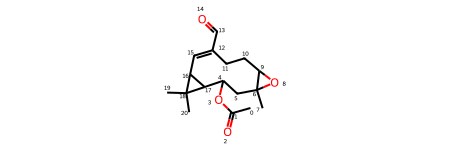

[16:20:29] The new font size 1 is below the current minimum (6).
[16:20:29] The new font size 1 is below the current minimum (6).
[16:20:30] The new font size 1 is below the current minimum (6).


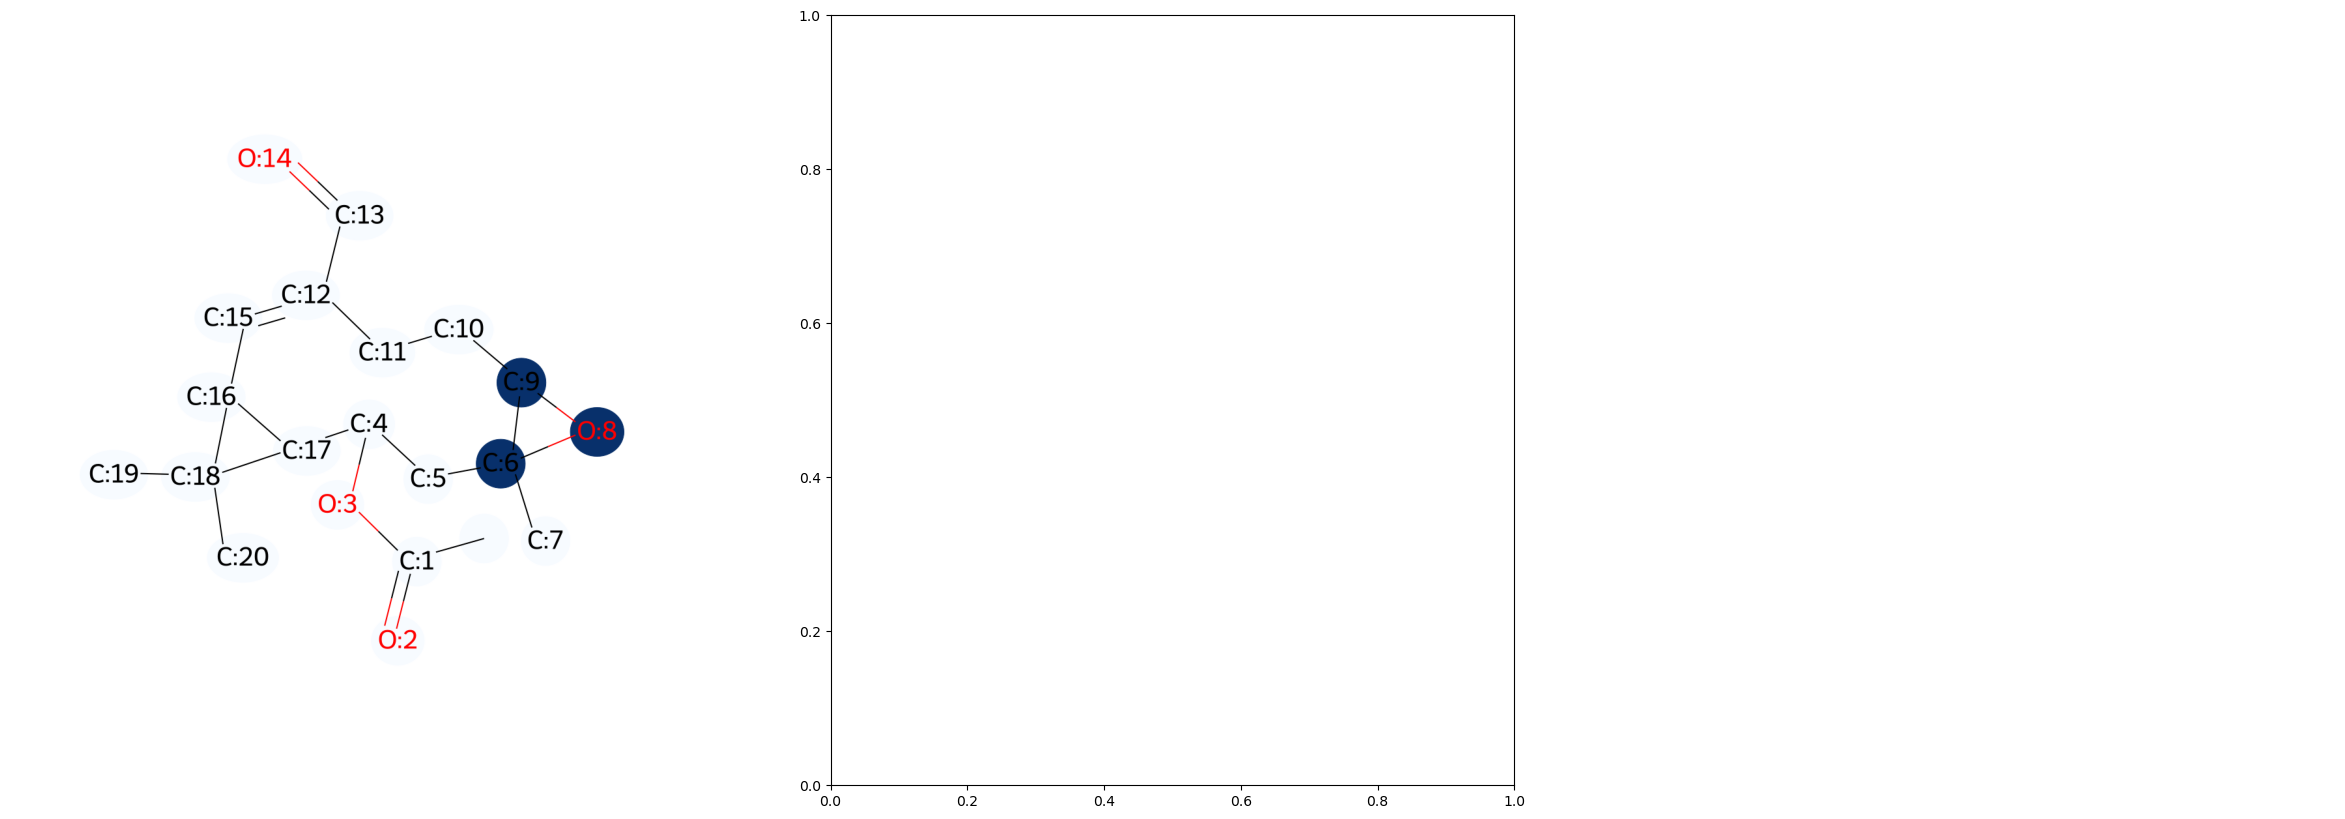

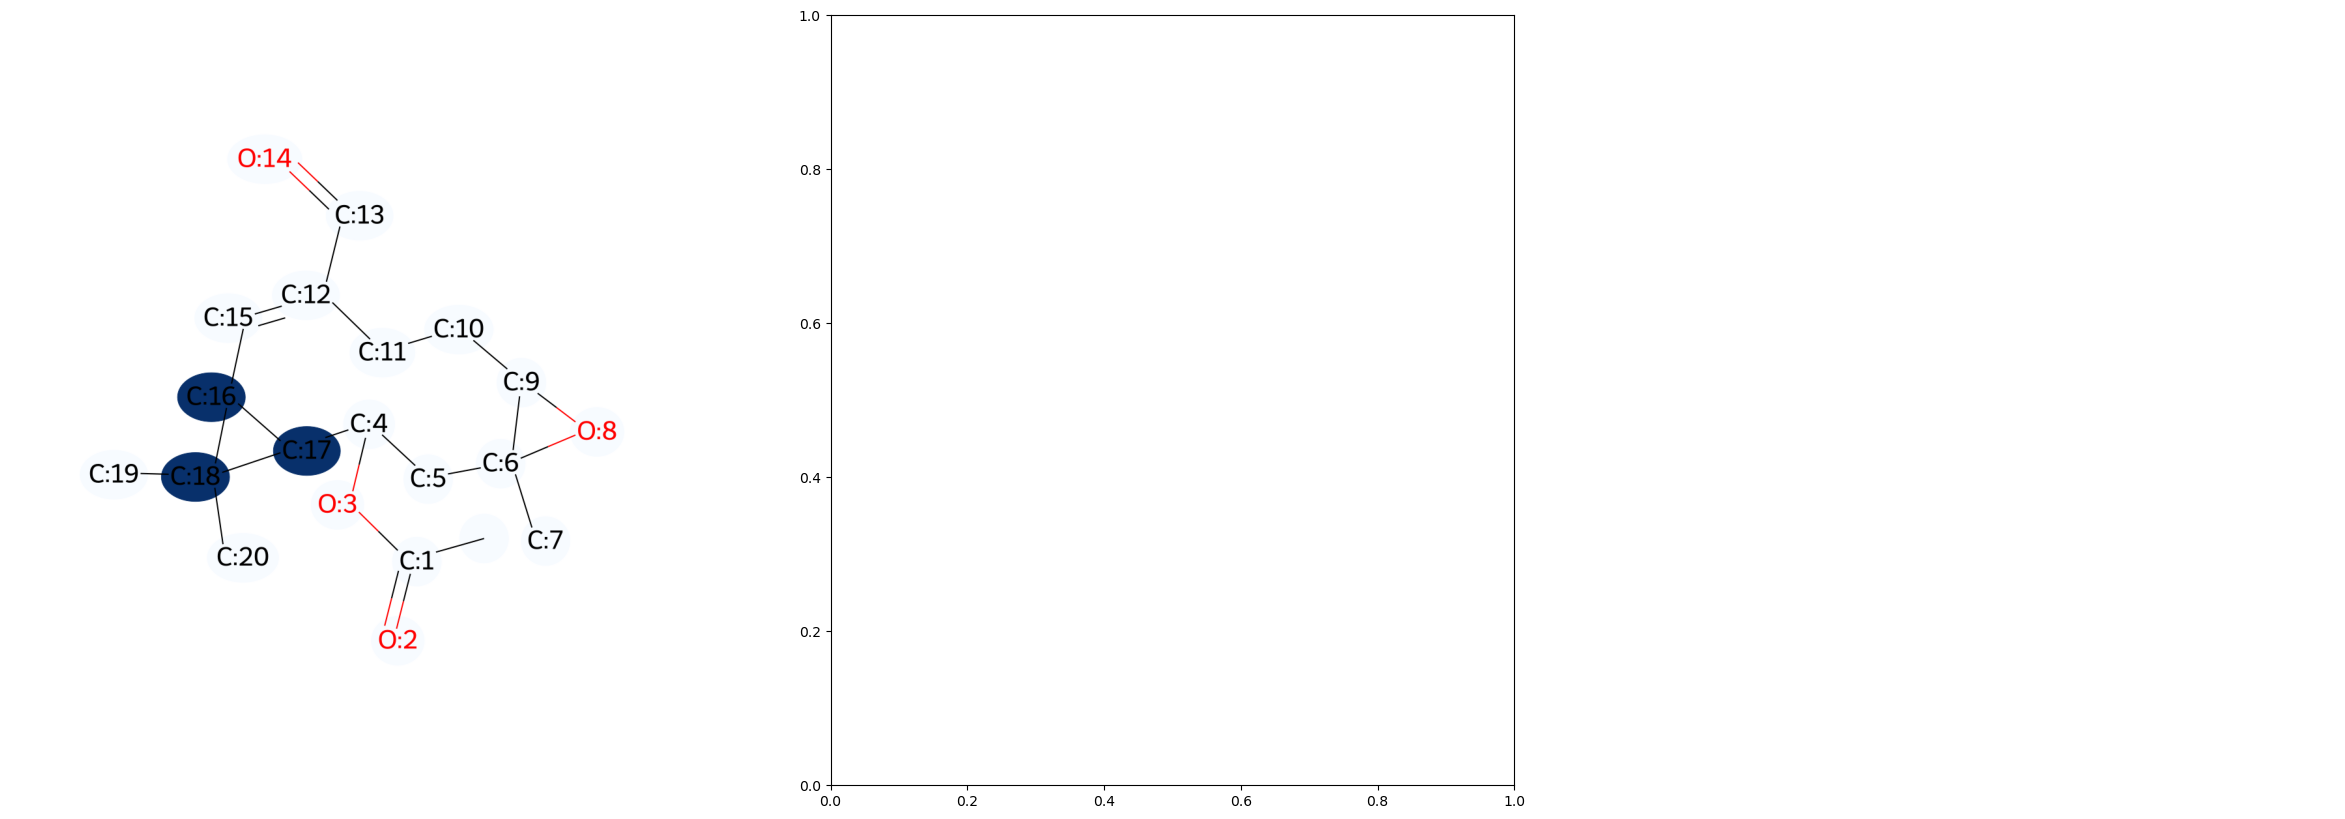

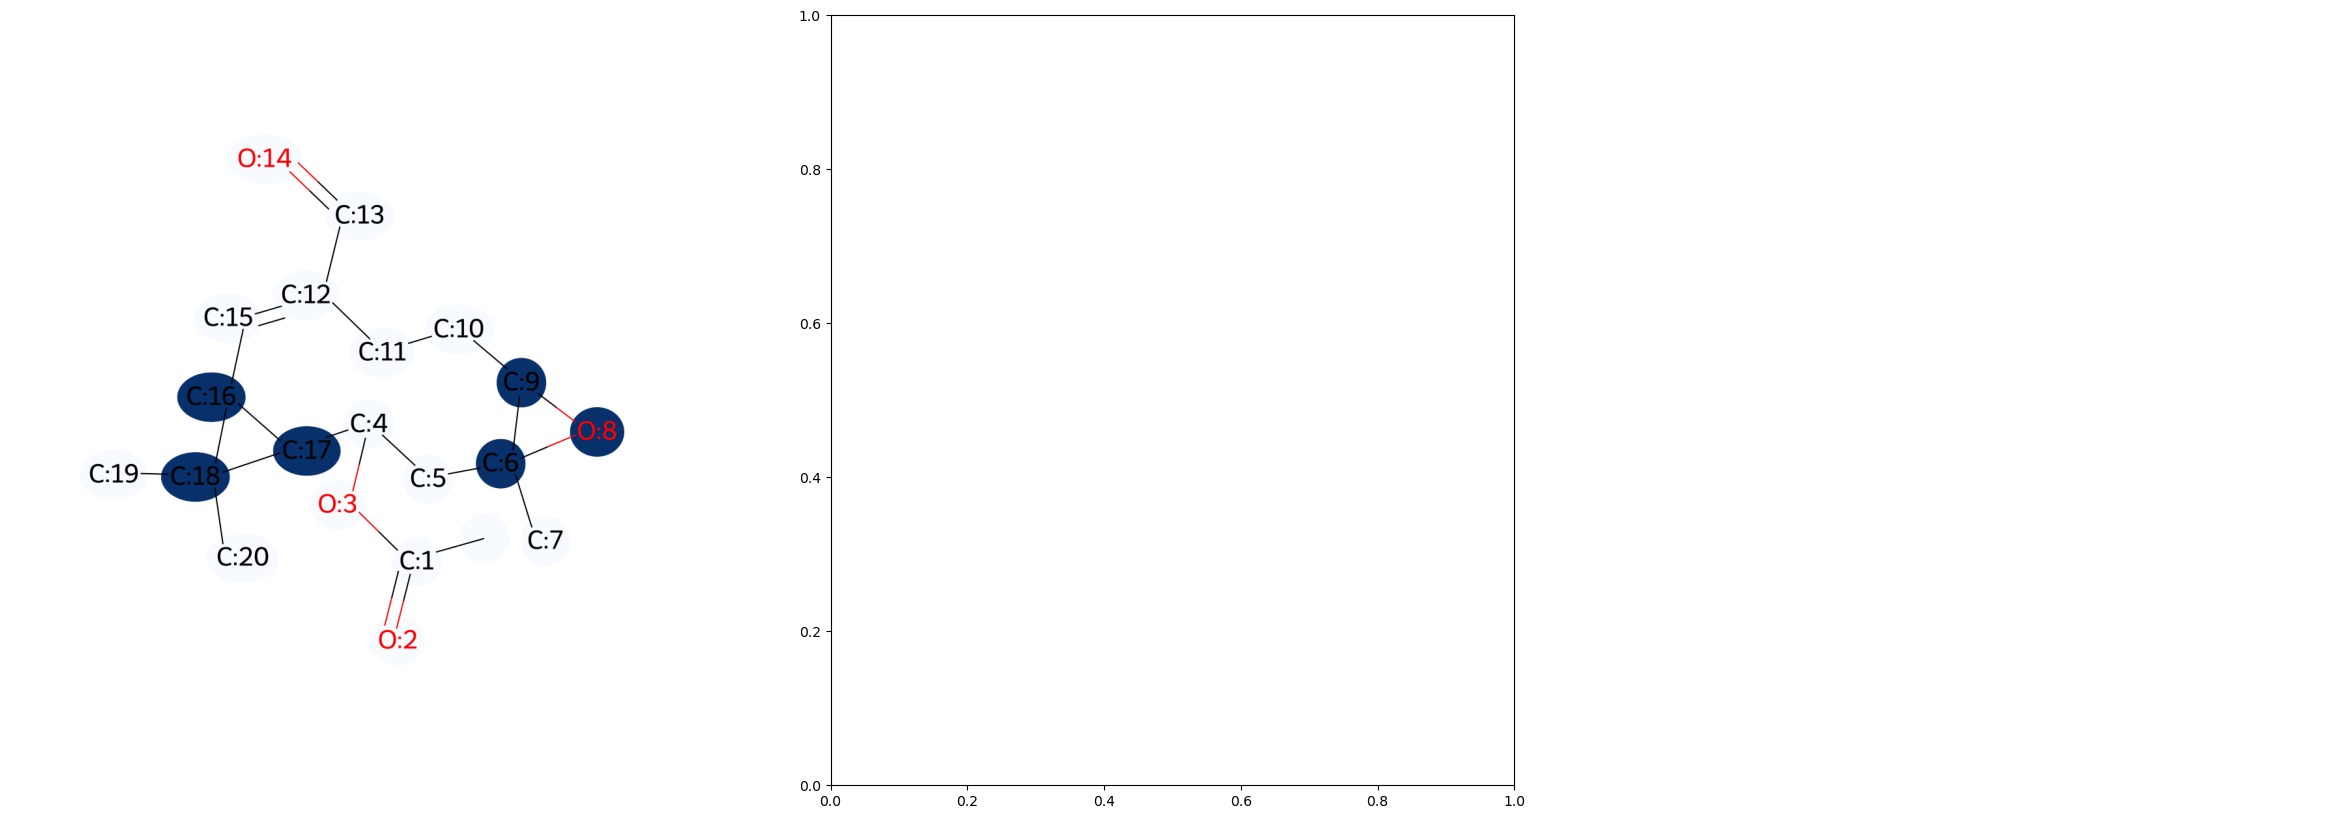

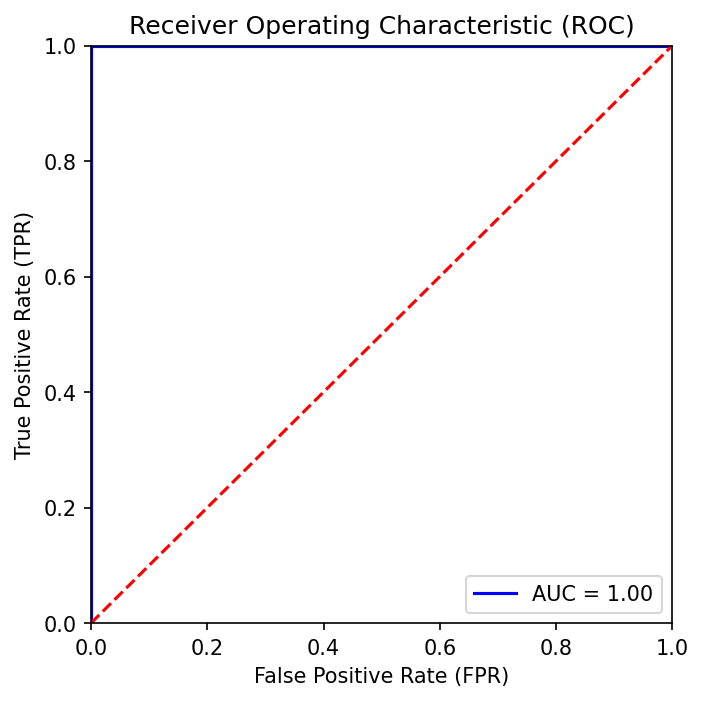

[0.003711370255521207, 0.0009200008851212443, 0.0035910908917371476, 0.0018415125150383488, 0.0006480963327797629, 0.016619642677880714, 0.6850625991683195, 0.025146742788356588, 1.0000000000000002, 0.6403106822350974, 0.018192557985796595, 0.002485730817002693, 0.0007340084530777363, 0.0016249031175083056, 0.003828583051653428, 0.0009714669074115806, 0.0005435423107952309, 0.0004938313797125948, 0.0, 0.0032452007932333576, 0.0032452007932333576]
accurary 1.0
jaccard 1.0


[16:20:31] The new font size 1 is below the current minimum (6).
[16:20:31] The new font size 1 is below the current minimum (6).
  0%|          | 0/6 [00:02<?, ?it/s]


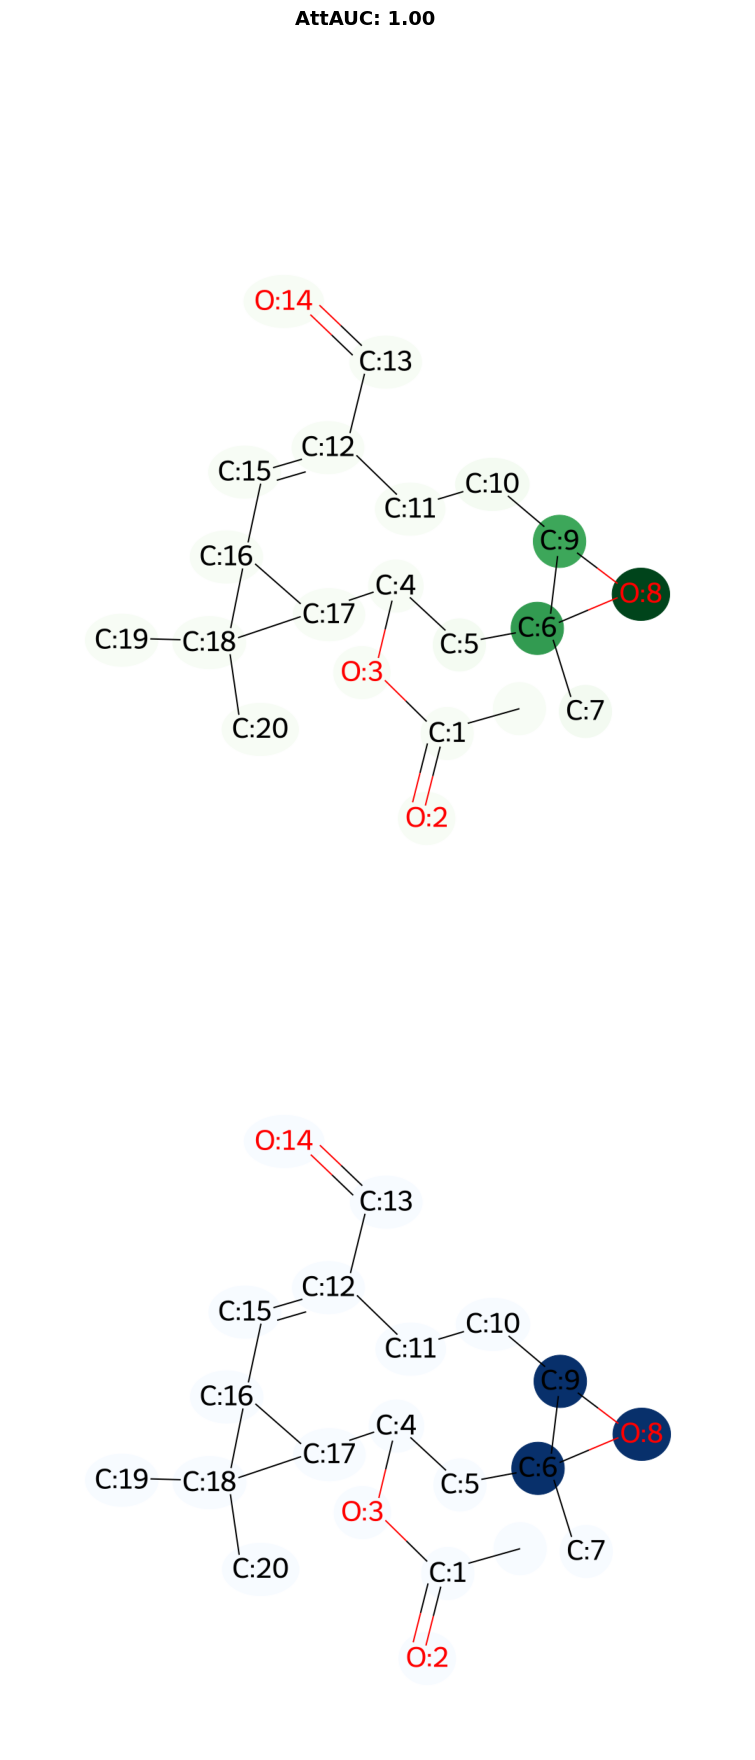

In [42]:
count = 0 
tester = Tester(args, args_test)

b = False
count_outlier = 0

testing_list_dict = {
'logic6': 
['O=C(Nc1nc(-c2ccc(OC(F)F)cc2)cs1)c1ccccc1',
'Cc1nc(C(F)(F)F)ccc1C(=O)NNC(=O)c1ccccc1F',
'O=C(NCC[NH+]1CCCCC1)[C@@H]1COc2ccc(F)cc2C1',
'O=C(N[C@H]1C[C@@H]1c1ccccc1F)c1c(Cl)ccc(Cl)c1Cl'],
'logic7': 
['CCOC(=O)c1sc(NC(=O)/C=C/c2ccc(F)cc2)nc1C',
'CCOC(=O)[C@@H](C)N1C(=O)S/C(=C\c2cc(Br)c(O)c(OC)c2)C1=O',
'O=C([O-])CCCCCN1C(=O)/C(=C\c2ccncc2)SC1=S',
# 'O=C([O-])/C=C/CC[C@@H]1SC[C@H]2NC(=O)N[C@@H]12', # error
'O=C(CC[NH+]1CCN(CCO)CC1)Nc1ccc(Br)cc1',
'CCCNC(=O)C[NH+]1CCC(NC(=O)/C=C/c2csc(C)n2)CC1',
'CCOC(=O)C1=C(C)C(C(=O)Nc2ccc(F)cc2F)=N[C@H]1C',
'CC/C=C(\C)C(=O)N1CSC[C@@H]1C(=O)N1CCCSCC1',
'COCC1=C[C@@H](CNC(=O)[C@@H]2c3cc(OC)ccc3N(C)[C@@H]2C)N=N1',
'O=C1OCCN1Cc1ccc(/N=C(\O)NCCc2ccccc2)cc1'],
'logic9': 
['NC(=O)NC(=O)OCCSc1nnc(Nc2ccccc2)s1',
'C[C@H]1C[C@H]([NH2+]N)CCN1C(=O)OCc1ccccc1',
'CCn1cc([C@H]2OCC[C@@H]2C[NH2+][C@H](C(N)=O)c2ccccc2)cn1',
'CC1(C)C[C@@H]([C@@H](CC(N)=O)c2ccccc2)CCO1',
'COC(=O)c1ccc(N2CC[NH+](Cc3ccccc3)CC2)c(N)c1'],
'logic14': 
['Cc1cccc(OCC(=O)Nc2cccc3ccccc23)c1',
'CCOC(=O)/C(=N/Nc1ccccc1)S(=O)(=O)c1ccccc1',
'O=C1O[C@H](c2ccccc2)[C@@](O)(c2ccccc2)C12CCCC2',
'CC(C)C[C@H](NC(=O)C[NH3+])C(=O)N[C@@H](Cc1ccccc1)C(=O)[O-]',
'CC(C)CCN1C(=O)c2ccc(C(=O)O[C@@H]3CCOC3=O)cc2C1=O',
'Clc1ccc(-c2onc3ccc(C#Cc4ccccc4)cc23)cc1', #False
'Cn1c(=O)[nH]c(=O)c2c1ncn2CC(=O)N/N=C\c1ccccc1O', #False
'CNC(=O)[C@H]1CCC[N@@H+]1CC#Cc1ccc(C(F)(F)F)cc1', #False
'CCn1c(C[NH+](C)C)nc2c(O)c(Cl)cc(Cl)c2c1=O', #False
'CC[NH+](CC)CCN1C(=O)C(O)=C(C(C)=O)[C@@H]1c1ccc(F)cc1'], #False
'3mr': 
['CC(=O)OC1CC2(C)OC2CCC(C=O)=CC2C1C2(C)C',
'CCOC(=O)C1OC1C(=O)NC(CC(C)C)C(=O)NCCC(C)C',
'CC1CC2OC2CC1COC(=O)C1CC2OC2CC1C',
'CCCn1c(=O)c2nc(C3CC4CC3C3OC43)[nH]c2n(CCC)c1=O',
'C=C1CC(OC(=O)C2(C)CO2)C2C(=C)C(=O)OC2C2C(=C)C(O)CC12',
'CC1=C(O)C(=O)C2OC2C1=O'],
'aromaticity': 
['CCSc1ncc(Cl)c(C(=O)Nc2cccc(Cl)c2)n1', #12
 'N=c1sccn1CC(=O)NC(=O)NC1CCCC1', #5
 'CCc1nnc(NC(=O)CSc2nc3cccnc3n2C2CCCCC2)s1', #14
'Cc1nnc(SCC(=O)NC2CCCCCC2)n1N', #5
'N=c1c2c(-c3ccccc3)c(-c3ccccc3)n(Cc3ccco3)c2ncn1Cc1ccccc1', #32
'CN(C)CN1CSC(=S)N(CN(C)C)C1'] #0
}

testing_list = testing_list_dict[args.file]

for d in tqdm(testing_list):
    # data loader
    test_loader, datasets_test =  generateDataLoaderListing([all_dataset[d]], 1)
    molecule_test = datasets_test[0]

    # testing
    # print(datasets_test)
    try:
        predicted = tester.test_single(test_loader, return_attention_weights=True, print_result=False)
    except:
        predicted = None

    if predicted != molecule_test.y:
        print(molecule_test.smiles, "TRUE:", molecule_test.y, "PREDICTED:", predicted)

    # if predicted == 1 or args.task == 'graphtask':
    if predicted is not None:
        count += 1

        # attention result
        att_mol = tester.getAttentionMol()
        sample_att = att_mol
        sample_graph = molecule_test
        if 'atom' in sample_att:
            sample_att_g = sample_att['atom']
        else:
            sample_att_g = None
        if len(args.reduced) != 0:
            sample_att_r = sample_att[args.reduced[0]]
        else:
            sample_att_r = None
        # sample_att_g, sample_att_r = sample_att
        if args.schema in ['A', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_g = mask_graph(sample_att_g)
        if args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_r = mask_reduced(sample_att_r)

        # molecule
        smiles = sample_graph.smiles
        mol = Chem.MolFromSmiles(smiles)
        display(mol)

        # reduced graph
        if args.schema in ['A']:
            reduced_graph, cliques, edges = getReducedGraph(args, ['atom'], smiles, normalize=False)
        else:
            reduced_graph, cliques, edges = getReducedGraph(args, args.reduced, smiles, normalize=False)

        # record importance
        mask_graph_x = None
        if args.schema in ['A']:
            mask_graph_x = mask_graph_g
        elif args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_x = mask_graph_r

        if predicted == 1 or args.graphtask == 'regression':

            if not args.schema in ['A']:
                mask_graph_x = mask_rtog(smiles, cliques, mask_graph_r)
                if args.schema in ['AR', 'AR_0', 'AR_N']:
                    mask_graph_x = mask_gandr(mask_graph_g, mask_graph_x)
                    display_interpret_weight(mol, cliques, edges, mask_graph_g, mask_graph_r, scale=True)
            
            # display_interpret_weight(mol, None, None, mask_graph_x, None, scale=True)
            
            if predicted == molecule_test.y or args.graphtask == 'regression':
                att_groundtruth = np.array(logic_dataset.match(mol), dtype=int)

                if or_case:
                    att_groundtruth_or = np.array(logic_dataset_or.match(mol), dtype=int)
                    att_more = list()
                    for att in att_groundtruth:
                        for att_or in att_groundtruth_or:
                            or_list = list(att | att_or)
                            att_more.append(or_list)
                    if len(att_more) > 0:
                        att_groundtruth = np.concatenate((att_groundtruth, att_more))

                if len(att_groundtruth)== 0:
                    print(att_groundtruth)
                    print(smiles)
                    # print(att_groundtruth_x[d])
                    continue
                
                assert len(list(mask_graph_x['atom'].values())) == len(att_groundtruth[0])
                # print(list(mask_graph_x['atom'].values()))
                # print(att_groundtruth)

                finding_max = -999
                finding_max_selected = list()
                list_roc = list()
                list_acc = list()
                list_jac = list()
                temp_index = list()
                temp_weight = list()
                # print(att_groundtruth)
                attention_prob = list(mask_graph_x['atom'].values())

                for t in att_groundtruth:
                    try:
                        if sum(t) == 0:
                            list_roc.append(0)
                        else:
                            roc = roc_auc_score(t, attention_prob)
                            list_roc.append(roc)
                            # print('Ground truth:', t)
                            # print('Model attrib:', np.sum(attention_prob), attention_prob)
                            # print('ROC:', roc)
                            # accuracy
                            attention_prob_acc = [a > 0.5 for a in attention_prob]
                            # print(attention_prob_acc)
                            attention_prob_acc_score = accuracy_score(t, attention_prob_acc)
                            list_acc.append(attention_prob_acc_score)
                            # print('ACC', attention_prob_acc_score)
                            # # method I: plt
                            # fpr, tpr, threshold = metrics.roc_curve(t, attention_prob)
                            # print(fpr, tpr, threshold)
                            # roc_auc = metrics.auc(fpr, tpr)
                            # fig = plt.figure(figsize=(5, 5), dpi=150)
                            # plt.title('Receiver Operating Characteristic (ROC)')
                            # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
                            # plt.legend(loc = 'lower right')
                            # plt.plot([0, 1], [0, 1], 'r--')
                            # plt.xlim([0, 1])
                            # plt.ylim([0, 1])
                            # plt.ylabel('True Positive Rate (TPR)')
                            # plt.xlabel('False Positive Rate (FPR)')
                            # plt.show()
                            attention_prob_jac_score = jaccard_score(t, attention_prob_acc)
                            list_jac.append(attention_prob_jac_score)
                            # print('JAC', attention_prob_jac_score)
                            
                    except:
                        pass

                    for tti, tt in enumerate(t):
                        temp_index.append(tti)
                        temp_weight.append(tt)

                    if roc > finding_max:
                        finding_max_selected = (temp_index, temp_weight)
                        finding_max = roc

                    # print(d)
                    # print(temp_weight)
                    # print(temp_index)
                    # print(finding_max)
                    plot_attentions_groundtruth(args, molecule_test, [[[temp_index,temp_index],temp_weight],None])

                    temp_index = list()
                    temp_weight = list()

                # print('MAX:', max(list_roc))
                if len(finding_max_selected) > 0: max_index, max_weight = finding_max_selected
                # plot_attentions_groundtruth(args, molecule_test, [[[max_index,max_index],max_weight],None])

                fpr, tpr, threshold = metrics.roc_curve(max_weight, attention_prob)
                # print(fpr, tpr, threshold)
                roc_auc = metrics.auc(fpr, tpr)
                fig = plt.figure(figsize=(5, 5), dpi=150)
                plt.title('Receiver Operating Characteristic (ROC)')
                plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
                plt.legend(loc = 'lower right')
                plt.plot([0, 1], [0, 1], 'r--')
                plt.xlim([0, 1])
                plt.ylim([0, 1])
                plt.ylabel('True Positive Rate (TPR)')
                plt.xlabel('False Positive Rate (FPR)')
                plt.show()
                print(attention_prob)
                if len(list_roc) > 0 and len(list_acc) > 0: print('accurary', list_acc[list_roc.index(max(list_roc))])
                if len(list_roc) > 0 and len(list_jac) > 0: print('jaccard', list_jac[list_roc.index(max(list_roc))])
                if len(list_roc) > 0 and len(list_acc) > 0 and len(list_jac) > 0:
                    plot_attentions_groundtruth_compare(mol, mask_graph_x, molecule_test, [[[max_index,max_index],max_weight],None], finding_max)

                # auroc.append(max(list_roc))
        
        elif predicted == 0 and false_case:
            
            if not args.schema in ['A']:
                mask_graph_x = mask_rtog(smiles, cliques, mask_graph_r)
                if args.schema in ['AR', 'AR_0', 'AR_N']:
                    mask_graph_x = mask_gandr(mask_graph_g, mask_graph_x)
            
            # display_interpret_weight(mol, None, None, mask_graph_x, None, scale=True)
            
            if predicted == molecule_test.y:
                att_groundtruth_false = np.array(logic_dataset_false.match(mol), dtype=int)

                if or_case:
                    att_groundtruth_or_false = np.array(logic_dataset_or_false.match(mol), dtype=int)
                    att_more = list()
                    for att in att_groundtruth_false:
                        for att_or in att_groundtruth_or_false:
                            or_list = list(att | att_or)
                            att_more.append(or_list)
                    if len(att_more) > 0:
                        att_groundtruth_false = np.concatenate((att_groundtruth_false, att_more))

                if len(att_groundtruth_false)== 0:
                    print(att_groundtruth_false)
                    print(smiles)
                    # print(att_groundtruth_x[d])
                    continue
                
                assert len(list(mask_graph_x['atom'].values())) == len(att_groundtruth_false[0])
                # print(list(mask_graph_x['atom'].values()))
                # print(att_groundtruth_false)

                finding_max = -999
                finding_max_selected = list()
                list_roc = list()
                list_acc = list()
                list_jac = list()
                temp_index = list()
                temp_weight = list()
                # print(att_groundtruth_false)
                attention_prob = list(mask_graph_x['atom'].values())

                for t in att_groundtruth_false:
                    try:
                        if sum(t) == 0:
                            list_roc.append(0)
                        else:
                            roc = roc_auc_score(t, attention_prob)
                            list_roc.append(roc)
                            # print('Ground truth:', t)
                            # print('Model attrib:', np.sum(attention_prob), attention_prob)
                            # print('ROC:', roc)
                            # accuracy
                            attention_prob_acc = [a > 0.5 for a in attention_prob]
                            # print(attention_prob_acc)
                            attention_prob_acc_score = accuracy_score(t, attention_prob_acc)
                            list_acc.append(attention_prob_acc_score)
                            # print('ACC', attention_prob_acc_score)
                            # # method I: plt
                            # fpr, tpr, threshold = metrics.roc_curve(t, attention_prob)
                            # print(fpr, tpr, threshold)
                            # roc_auc = metrics.auc(fpr, tpr)
                            # fig = plt.figure(figsize=(5, 5), dpi=150)
                            # plt.title('Receiver Operating Characteristic (ROC)')
                            # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
                            # plt.legend(loc = 'lower right')
                            # plt.plot([0, 1], [0, 1], 'r--')
                            # plt.xlim([0, 1])
                            # plt.ylim([0, 1])
                            # plt.ylabel('True Positive Rate (TPR)')
                            # plt.xlabel('False Positive Rate (FPR)')
                            # plt.show()
                            attention_prob_jac_score = jaccard_score(t, attention_prob_acc)
                            list_jac.append(attention_prob_jac_score)
                            # print('JAC', attention_prob_jac_score)
                            
                    except:
                        pass

                    for tti, tt in enumerate(t):
                        temp_index.append(tti)
                        temp_weight.append(tt)

                    if roc > finding_max:
                        finding_max_selected = (temp_index, temp_weight)
                        finding_max = roc

                    # print(d)
                    # print(temp_weight)
                    # print(temp_index)
                    # print(finding_max)
                    # plot_attentions_groundtruth(args, molecule_test, [[[temp_index,temp_index],temp_weight],None])

                    temp_index = list()
                    temp_weight = list()

                # print('MAX:', max(list_roc))
                if len(finding_max_selected) > 0: max_index, max_weight = finding_max_selected
                # plot_attentions_groundtruth(args, molecule_test, [[[max_index,max_index],max_weight],None])

                fpr, tpr, threshold = metrics.roc_curve(max_weight, attention_prob)
                # print(fpr, tpr, threshold)
                roc_auc = metrics.auc(fpr, tpr)
                fig = plt.figure(figsize=(5, 5), dpi=150)
                plt.title('Receiver Operating Characteristic (ROC)')
                plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
                plt.legend(loc = 'lower right')
                plt.plot([0, 1], [0, 1], 'r--')
                plt.xlim([0, 1])
                plt.ylim([0, 1])
                plt.ylabel('True Positive Rate (TPR)')
                plt.xlabel('False Positive Rate (FPR)')
                plt.show()
                if len(list_roc) > 0 and len(list_acc) > 0: print('accurary', list_acc[list_roc.index(max(list_roc))])
                if len(list_roc) > 0 and len(list_jac) > 0: print('jaccard', list_jac[list_roc.index(max(list_roc))])
                if len(list_roc) > 0 and len(list_acc) > 0 and len(list_jac) > 0:
                    plot_attentions_groundtruth_compare(mol, mask_graph_x, molecule_test, [[[max_index,max_index],max_weight],None], finding_max)

                # auroc.append(max(list_roc))
            
        else:
            display(mol)
                

    break
